<a href="https://colab.research.google.com/github/andervies/divic-corp-machine-learning-course/blob/main/assignment34/LSTM_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem One: Execution of various methods

Training Using LSTM

In [1]:
from __future__ import print_function

import numpy as np
import pylab as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv3D, ConvLSTM2D, BatchNormalization, GRU, SimpleRNN
from keras.datasets import imdb
from keras import backend as K

In [2]:
max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
17464789/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Epoch 1/3
782/782 [==============================] - 258s 319ms/step - loss: 0.4280 - accuracy: 0.8007 - val_loss: 0.3619 - val_accuracy: 0.8402
Epoch 2/3
782/782 [==============================] - 287s 367ms/step - loss: 0.2525 - accuracy: 0.8989 - val_loss: 0.3822 - val_accuracy: 0.8333
Epoch 3/3
782/782 [==============================] - 28s 36ms/step - loss: 0.4740 - accuracy: 0.8225
Test score: 0.47401878237724304
Test accuracy: 0.8225200176239014


Training Using ConvLSTM2D

Epoch 1/3
95/95 [==============================] - 2136s 22s/step - loss: 0.8792 - val_loss: 0.7174
Epoch 2/3
95/95 [==============================] - 2013s 21s/step - loss: 0.7711 - val_loss: 0.7854
Epoch 3/3
1/1 [==============================] - 1s 787ms/step


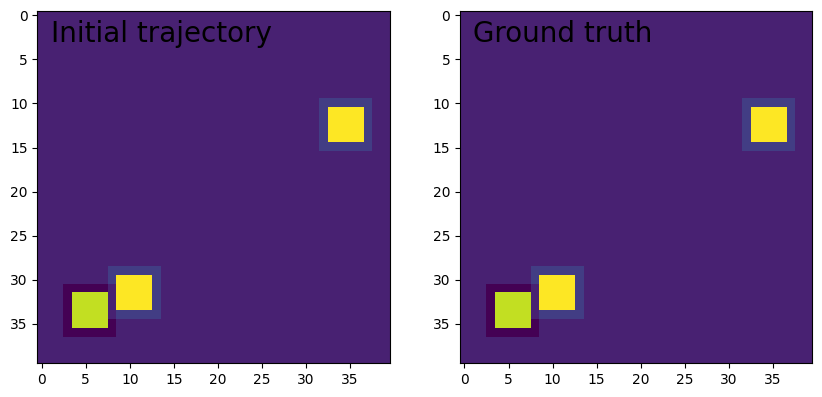

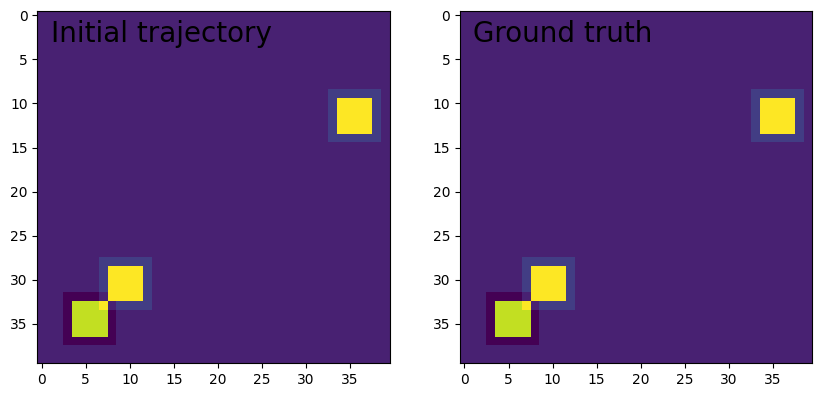

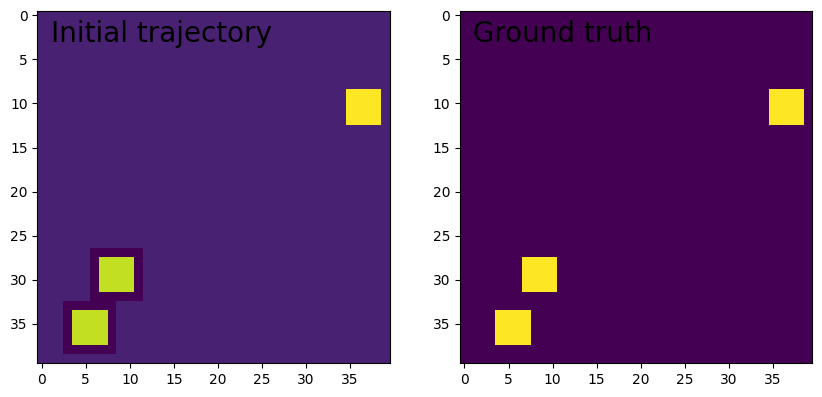

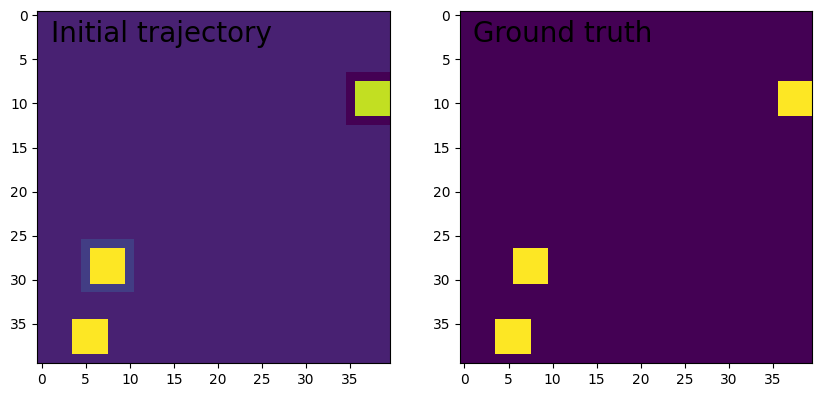

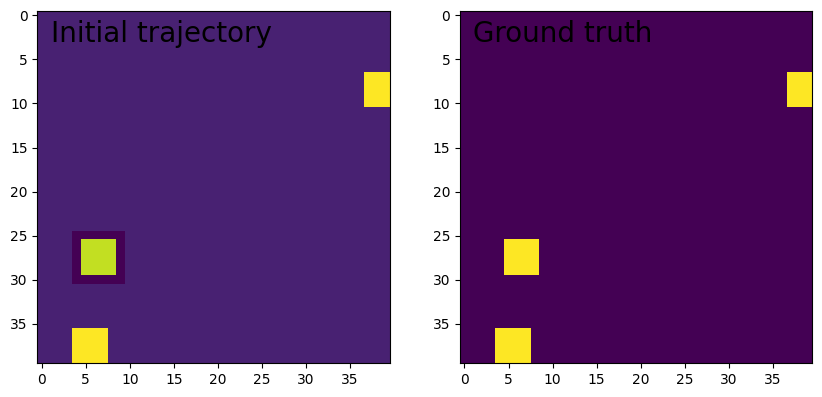

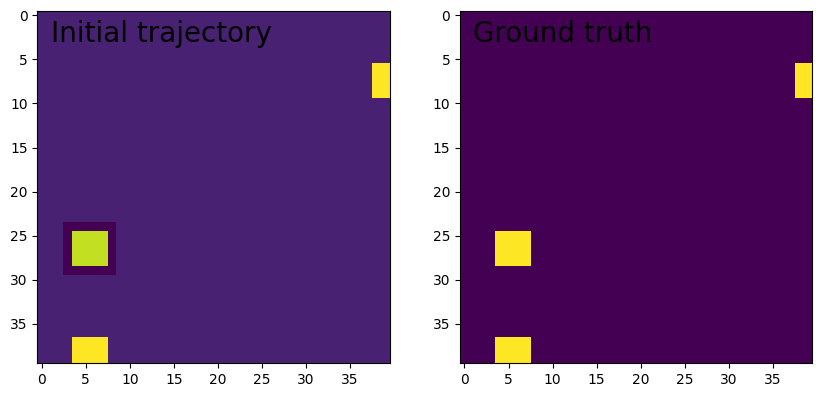

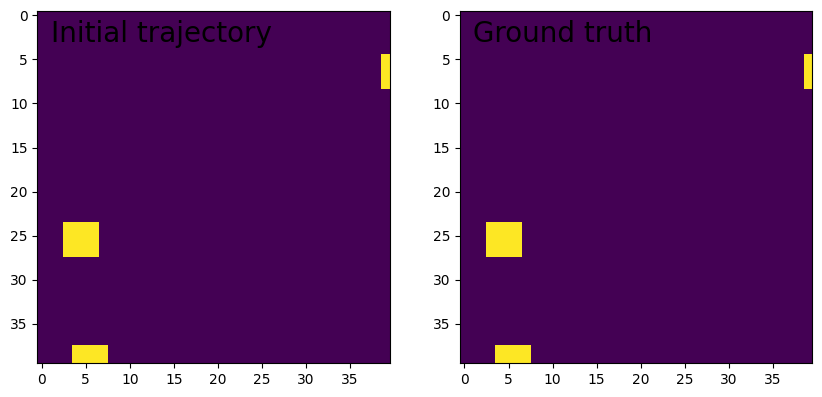

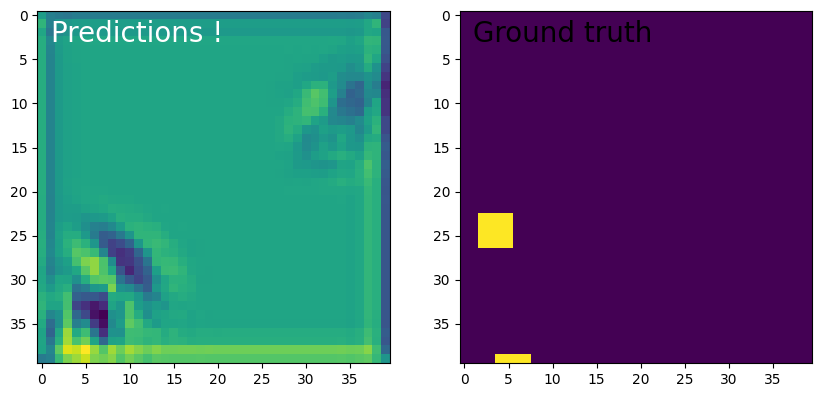

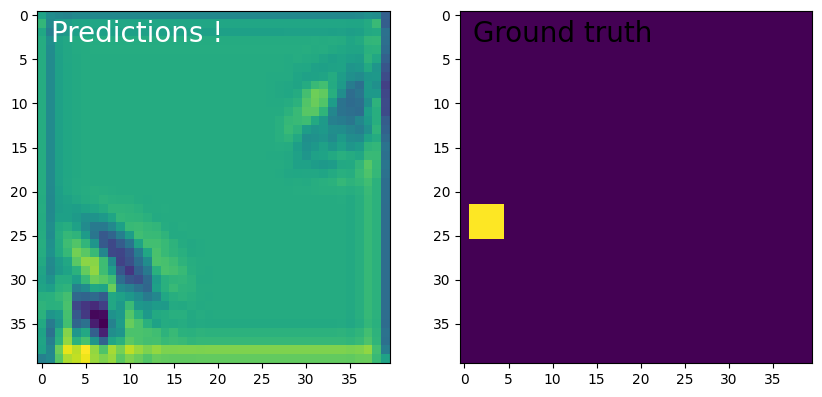

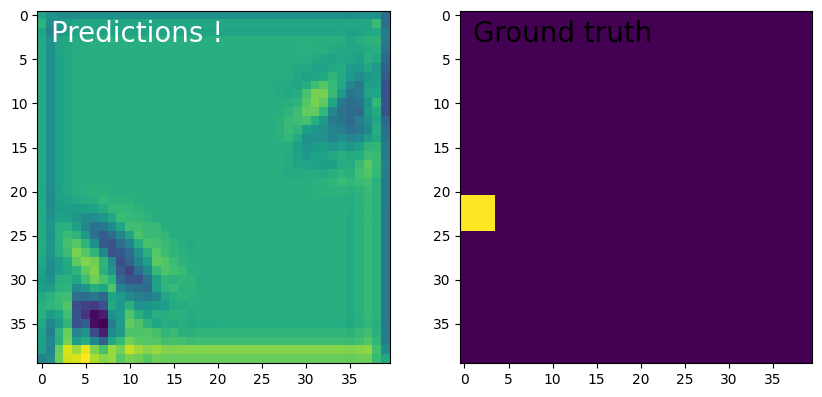

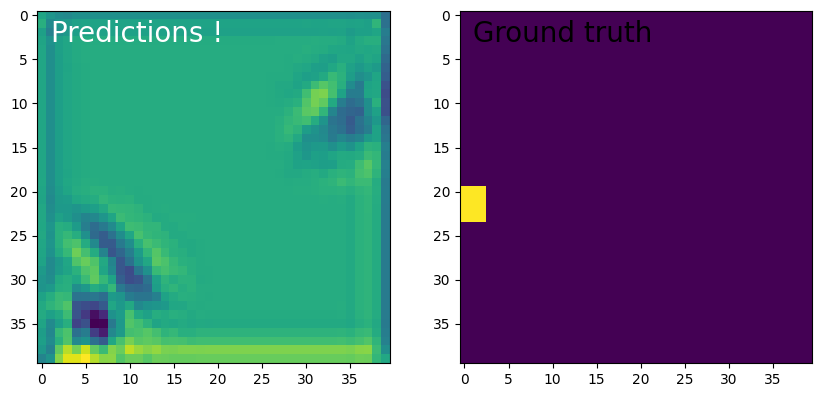

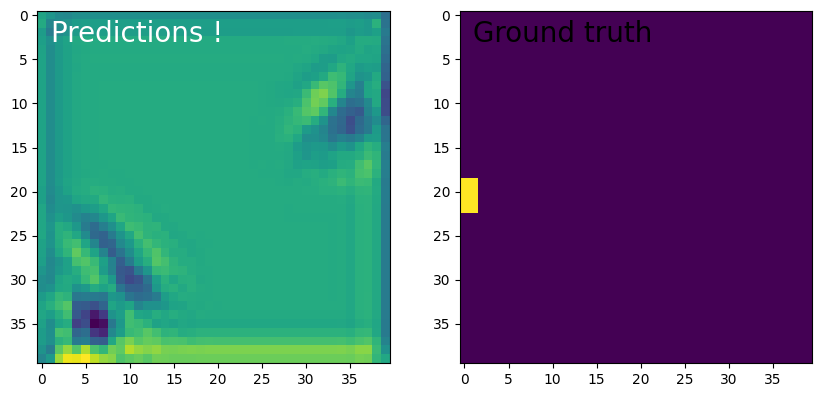

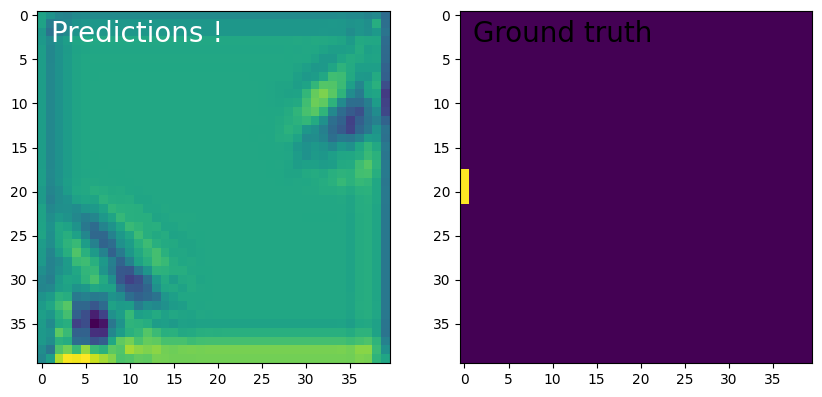

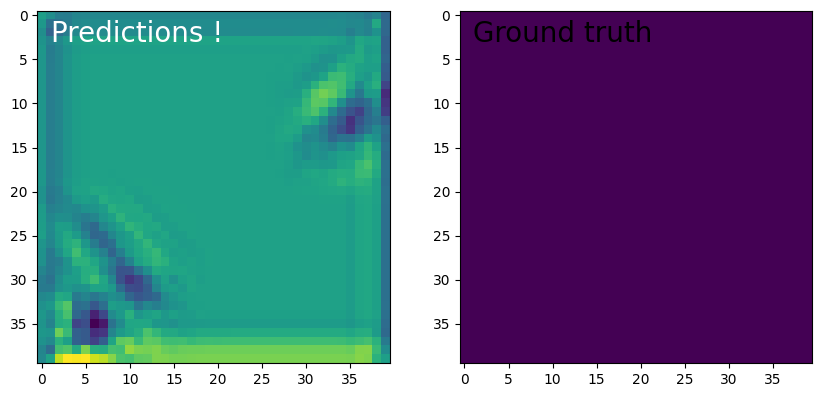

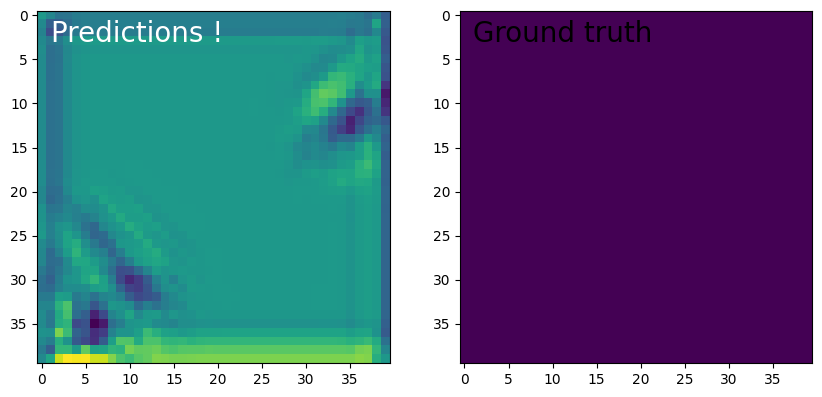

In [3]:
if K.backend() == 'mxnet':
    raise NotImplementedError("MXNet Backend: ConvLSTM2D Layer is not supported yet.")

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')


# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float_)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float_)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=3, validation_split=0.05)

# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))

Training Using SimpleRNN

In [ ]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

model.add(Embedding(max_features, 128))
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
17464789/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Epoch 1/3
782/782 [==============================] - 85s 104ms/step - loss: 0.6931 - accuracy: 0.5337 - val_loss: 0.6702 - val_accuracy: 0.5718
Epoch 2/3
782/782 [==============================] - 78s 100ms/step - loss: 0.6200 - accuracy: 0.6484 - val_loss: 0.5843 - val_accuracy: 0.6858
Epoch 3/3
782/782 [==============================] - 9s 12ms/step - loss: 0.5163 - accuracy: 0.7542
Test score: 0.5162909626960754
Test accuracy: 0.7541999816894531


Training Using GRU

In [ ]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

model.add(Embedding(max_features, 128))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Epoch 1/3
782/782 [==============================] - 221s 277ms/step - loss: 0.4521 - accuracy: 0.7810 - val_loss: 0.3655 - val_accuracy: 0.8448
Epoch 2/3
782/782 [==============================] - 238s 304ms/step - loss: 0.2526 - accuracy: 0.8987 - val_loss: 0.3499 - val_accuracy: 0.8488
Epoch 3/3
782/782 [==============================] - 24s 31ms/step - loss: 0.4105 - accuracy: 0.8355
Test score: 0.41052645444869995
Test accuracy: 0.8355200290679932


## Problem Three: Explanation of other classes

**RNN (Recurrent Neural Network)**  
RNNs are a class of neural networks designed to recognize patterns in sequences of data, such as time series or natural language. They have loops that allow information to be carried across network nodes, enabling them to maintain a memory of previous inputs. This makes them suitable for tasks like language modeling, translation, and speech recognition.  
  
  
**SimpleRNNCell**  
`SimpleRNNCell` is a basic building block for simple recurrent neural networks. It contains the logic for one time step of an RNN. The cell takes an input and the previous hidden state, processes them, and outputs a new hidden state. This operation is repeated for each time step in the input sequence.  
  
  
**GRUCell (Gated Recurrent Unit Cell)**  
`GRUCell` is a variant of the RNN cell that includes gating mechanisms to better capture dependencies in the data. It has two gates, a reset gate and an update gate, which help control the flow of information and mitigate the vanishing gradient problem. GRUs are often preferred over basic RNN cells due to their efficiency and performance.  
  
  
**LSTMCell (Long Short-Term Memory Cell)**  
`LSTMCell` is another variant of the RNN cell that is designed to capture long-term dependencies more effectively. It includes three gates: input, output, and forget gates. These gates regulate the flow of information into, out of, and within the cell, allowing it to maintain a more robust memory of past inputs. LSTMs are widely used for their ability to handle long-range dependencies in sequences.  
  
  
**StackedRNNCells**  
`StackedRNNCells` is a mechanism to stack multiple RNN cells on top of each other to create a deeper network. This can enhance the model's capacity to learn complex patterns by providing multiple layers of recurrent processing. It is commonly used to build deeper and more powerful recurrent networks.  
  
  
**CuDNNGRU**  
`CuDNNGRU` is a highly optimized implementation of GRU cells specifically designed to run on NVIDIA GPUs using the CuDNN library. This version offers significant performance improvements over standard GRU implementations, making it suitable for training large models on GPUs efficiently.  
  
  
**CuDNNLSTM**  
`CuDNNLSTM` is the GPU-optimized version of LSTM cells, also using the CuDNN library. Similar to CuDNNGRU, it provides faster training and inference times by leveraging GPU acceleration. This makes it ideal for large-scale sequence modeling tasks where training speed is a critical factor.  

These components play essential roles in building and optimizing recurrent neural networks for various sequence-based tasks, each with its specific advantages and use cases.
